## How to succeed in Airbnb Boston's market

### Business Understanding
From the dataset is possible to know what are the preference of the users when they are staying in Boston. We will try to answer this questions using the dataset:

- What do the users look for in an Airbnb?
- What impacts the prices negatively?
- What room type gets better reviews?

### Data Understandin
Boston Airbnb dataset consists of 3585 rows and 95 columns, each row is a listing 

### Prepare Data
The columns were cleaned, the NAN values filled with the mean and the median according to the needs and the qualitative data processed,  more details in the Preprocessing section 

### Data Modeling:
Using the Linear Regression model on the processed data, and getting the coefficients of every feature we can know the relevance of each feature, more details in the Result section 

### Results and discussion: 
Published in https://medium.com/@scabrujas/how-to-succeed-in-airbnb-bostons-market-7807a116d6f5

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer

listing = pd.read_csv("./boston/listings.csv")

In [2]:
def process_data(listing):
    #Drop columns with more than 50% null values
    to_drop = listing.columns[(np.sum(listing.isnull()) / listing.shape[0]) > .5].tolist()
    listing.drop(to_drop, axis=1, inplace=True)

    #Formatting the column price
    listing['price']=listing['price'].apply(lambda x: float(x[1:].replace(',','')))
    df=listing

    #Since the 90% of the values are under 500 I will ignore the values over 500 
    #in order to get a better model
    drop_price_index=listing[listing.price > 500].index
    listing.drop(drop_price_index, axis = 0, inplace = True)

    col=['price','bedrooms','accommodates','bathrooms','beds','number_of_reviews',
         'room_type','property_type','bed_type','host_since','latitude','longitude','minimum_nights','maximum_nights', 
         'availability_30','availability_60','availability_90','availability_365',
         'reviews_per_month','review_scores_rating','review_scores_location','review_scores_accuracy',
         'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
         'review_scores_location','review_scores_value']

    listing.drop([i for i in listing.columns if i not in col], axis=1, inplace=True)

    # Preprocess the 'host_since' column
    today = datetime.strptime('2020-03-16','%Y-%m-%d')
    listing['host_since'] = listing['host_since'].apply(lambda x: (today - datetime.strptime(x, '%Y-%m-%d')).days)

    #dealing with missing values grouping by category and filling with the meadian
    listing.bathrooms.fillna(listing.groupby("bedrooms")["bathrooms"].transform("median"), inplace=True)
    listing.beds.fillna(listing.groupby("bedrooms")["beds"].transform("median"), inplace=True)
    listing.bedrooms.fillna(listing.groupby("bathrooms")["beds"].transform("median"), inplace=True)

    #rest of the quantitative values are filled with the mean
    quant_fill = ['number_of_reviews','reviews_per_month','latitude','longitude','minimum_nights','maximum_nights', 
                  'availability_30','availability_60','availability_90','availability_365','reviews_per_month','review_scores_rating',
                  'review_scores_location','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
                  'review_scores_communication','review_scores_location','review_scores_value']

    for n in quant_fill:
        listing[n].fillna(listing[n].mean(), inplace = True)

    #Creating dummy variables for the qualitative variables
    cat_cols =  listing.select_dtypes(include=['object'])
    for col in cat_cols:
            try:
                listing = pd.concat([listing.drop(col, axis=1), pd.get_dummies(listing[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
            except:
                continue
                
    sns.set()
    dist = sns.distplot(listing['price'],bins=100)
    
    return listing, df

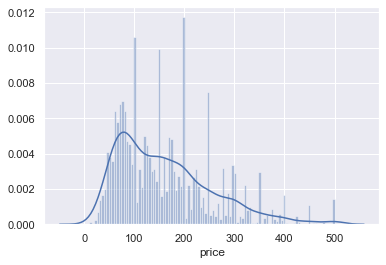

In [3]:
listing,df = process_data(listing)

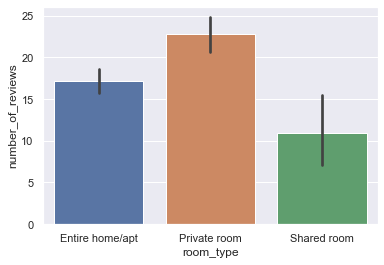

In [4]:
sns.barplot(x="room_type", y="number_of_reviews", data=df);

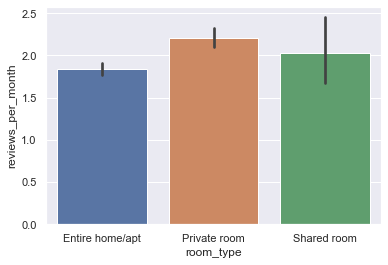

In [5]:
sns.barplot(x="room_type", y="reviews_per_month", data=df);

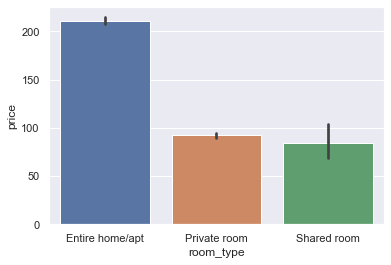

In [6]:
sns.barplot(x="room_type", y="price", data=df);

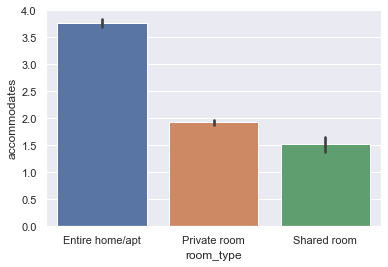

In [7]:
sns.barplot(x="room_type", y="accommodates", data=df);

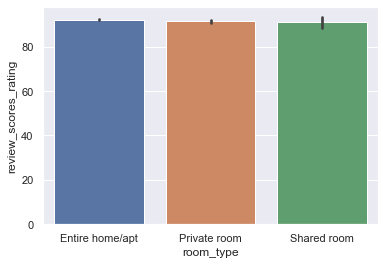

In [8]:
sns.barplot(x="room_type", y="review_scores_rating", data=df);

In [9]:
def model(listing):
    #Split into explanatory and response variables
    X = listing.drop('price', axis=1)
    y = listing['price']

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    #return test_score, train_score, lm_model, X_train, X_test, y_train, y_test
    print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))
    
    #getting the coefficients
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)

    coefs_df.sort_values(by=['coefs'],ascending=False,inplace=True)
    
    #getting the top and the bottom 10 features
    top = coefs_df.head(10)
    bottom = coefs_df.tail(10)
    
    plt.figure(figsize=(8,3))
    plt.bar(top['est_int'],top['coefs'])
    plt.xticks(rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Features Relevance')
    plt.title('Top 10 features')
    plt.show()
    
    plt.figure(figsize=(8,3))
    plt.bar(bottom['est_int'],bottom['coefs'])
    plt.xticks(rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Features Relevance')
    plt.title('Bottom 10 features')
    plt.show()    

The rsquared on the training data was 0.5847369707799948.  The rsquared on the test data was -15149.177822383113.


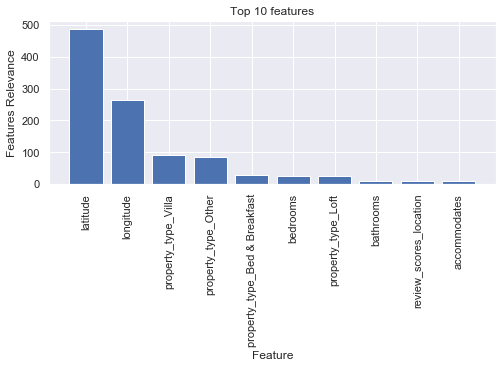

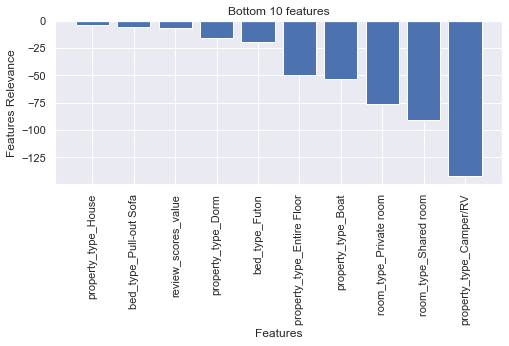

In [10]:
model(listing)

In [11]:
df = df.groupby('room_type')['number_of_reviews','reviews_per_month','review_scores_rating','price','accommodates'].mean()
df.reset_index(inplace=True)
df

,room_type,number_of_reviews,reviews_per_month,review_scores_rating,price,accommodates
0,Entire home/apt,17.179971,1.837416,92.169859,211.111272,3.761490
1,Private room,22.801165,2.204046,91.452219,92.080845,1.923525
2,Shared room,10.949367,2.027198,91.171565,84.443038,1.518987
